In [1]:
#import modules
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import NaiveBayes

from pyspark.ml.classification  import RandomForestClassifier
from pyspark.ml.feature import HashingTF, Tokenizer, StopWordsRemover

import praw
    
#create Spark session
appName = "Spark_SentimentAnalysis"
spark = SparkSession.builder.appName(appName).getOrCreate()


In [2]:
#read csv file into dataFrame with automatically inferred schema

data = spark.read.csv('Reddit_Data.csv', inferSchema=True, header=True)

print(type(data))
data.show(truncate=False, n=3)

<class 'pyspark.sql.dataframe.DataFrame'>
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------+
|SentimentText                                                                                                                                                                                                     |Sentiment|
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------+
|when modi promised “minimum government maximum governance” expected him begin the difficult job reforming the state why does take years get justice state should and not business and should exit psus and temples|0        |
|talk all the nonsense and continue all the drama will vote for mo

In [3]:
# drop the empty records (rows) from dataset.

data=data.na.drop()
data.show(truncate=False, n=3)

+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------+
|SentimentText                                                                                                                                                                                                     |Sentiment|
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------+
|when modi promised “minimum government maximum governance” expected him begin the difficult job reforming the state why does take years get justice state should and not business and should exit psus and temples|0        |
|talk all the nonsense and continue all the drama will vote for modi                                        

In [4]:
#select only "SentimentText" and "Sentiment" column, 
#and cast "Sentiment" column data into integer
data = data.select("SentimentText", col("Sentiment").cast("Int").alias("label"))
data.show(truncate = False,n=5)

+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+
|SentimentText                                                                                                                                                                                                       |label|
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+
|when modi promised “minimum government maximum governance” expected him begin the difficult job reforming the state why does take years get justice state should and not business and should exit psus and temples  |0    |
|talk all the nonsense and continue all the drama will vote for modi                                                

In [5]:
#divide data- 70% for training, 30% for testing

dividedData = data.randomSplit([0.7, 0.3])
trainingData = dividedData[0] #index 0 = data training
testingData = dividedData[1] #index 1 = data testing
train_rows = trainingData.count()
test_rows = testingData.count()
#print(type(testingData))
print ("Training data rows:", train_rows, "; Testing data rows:", test_rows)

Training data rows: 111342 ; Testing data rows: 47348


In [6]:
#Prepare training data
#Separate "SentimentText" into individual words using tokenizer

tokenizer = Tokenizer(inputCol="SentimentText", outputCol="SentimentWords")

tokenizedTrain = tokenizer.transform(trainingData)

tokenizedTrain.show(truncate=False, n=5)

+------------------------------------------+-----+----------------------------------------------------+
|SentimentText                             |label|SentimentWords                                      |
+------------------------------------------+-----+----------------------------------------------------+
|   "                                      |0    |[, , , "]                                           |
|   modi invested make australia apples lol|1    |[, , , modi, invested, make, australia, apples, lol]|
| "                                        |0    |[, "]                                               |
| "                                        |0    |[, "]                                               |
| "                                        |0    |[, "]                                               |
+------------------------------------------+-----+----------------------------------------------------+
only showing top 5 rows



In [7]:
#Removing stop words (unimportant words to be features)

swr = StopWordsRemover(inputCol=tokenizer.getOutputCol(),outputCol="MeaningfulWords")

SwRemovedTrain = swr.transform(tokenizedTrain)

SwRemovedTrain.show(truncate=False, n=5)


+------------------------------------------+-----+----------------------------------------------------+----------------------------------------------------+
|SentimentText                             |label|SentimentWords                                      |MeaningfulWords                                     |
+------------------------------------------+-----+----------------------------------------------------+----------------------------------------------------+
|   "                                      |0    |[, , , "]                                           |[, , , "]                                           |
|   modi invested make australia apples lol|1    |[, , , modi, invested, make, australia, apples, lol]|[, , , modi, invested, make, australia, apples, lol]|
| "                                        |0    |[, "]                                               |[, "]                                               |
| "                                        |0    |[, "]   

In [8]:
#Converting words feature into numerical feature. 
#In Spark,it is implemented in HashingTF funtion using Austin Appleby's MurmurHash3 (mmh3) algorithm.
#a set of fast and robust hash function.


hashTF = HashingTF(inputCol=swr.getOutputCol(), outputCol="features",numFeatures=500)

numericTrainData = hashTF.transform(SwRemovedTrain).select('label', 'MeaningfulWords', 'features')

numericTrainData.show(truncate=False, n=3)

+-----+----------------------------------------------------+----------------------------------------------------------------+
|label|MeaningfulWords                                     |features                                                        |
+-----+----------------------------------------------------+----------------------------------------------------------------+
|0    |[, , , "]                                           |(500,[19,372],[1.0,3.0])                                        |
|1    |[, , , modi, invested, make, australia, apples, lol]|(500,[25,189,372,405,410,439,444],[1.0,1.0,3.0,1.0,1.0,1.0,1.0])|
|0    |[, "]                                               |(500,[19,372],[1.0,1.0])                                        |
+-----+----------------------------------------------------+----------------------------------------------------------------+
only showing top 3 rows



In [9]:
# Prepare testing data
tokenizedTest = tokenizer.transform(testingData)

SwRemovedTest = swr.transform(tokenizedTest)

numericTest = hashTF.transform(SwRemovedTest).select('Label', 'MeaningfulWords', 'features')

numericTest.show(truncate=False, n=2)

+-----+------------------------+----------------------------------------+
|Label|MeaningfulWords         |features                                |
+-----+------------------------+----------------------------------------+
|1    |[, , great, distress, "]|(500,[19,250,325,372],[1.0,1.0,1.0,2.0])|
|1    |[, "]                   |(500,[19,372],[1.0,1.0])                |
+-----+------------------------+----------------------------------------+
only showing top 2 rows



In [10]:
#Train our classifier model using training data.

#LogisticRegression

lr = LogisticRegression(labelCol="label", featuresCol="features",maxIter=10, regParam=0.01)

lr_model = lr.fit(numericTrainData)

#Predict testing data and calculate the accuracy model

prediction = lr_model.transform(numericTest)

predictionFinal = prediction.select("MeaningfulWords", "prediction", "Label")

predictionFinal.show(n=4, truncate = False)

correctPrediction = predictionFinal.filter(predictionFinal['prediction'] == predictionFinal['Label']).count()

totalData = predictionFinal.count()

print("correct prediction:", correctPrediction, ", total data:", totalData,", accuracy:", correctPrediction/totalData)

lr_summary = lr_model.summary

lr_accuracy = lr_summary.accuracy




print("LogisticRegression of Performance Metrics:")
print("Accuracy:",lr_accuracy)









+------------------------+----------+-----+
|MeaningfulWords         |prediction|Label|
+------------------------+----------+-----+
|[, , great, distress, "]|1.0       |1    |
|[, "]                   |0.0       |1    |
|[, "]                   |0.0       |2    |
|[, acchedin, "]         |0.0       |1    |
+------------------------+----------+-----+
only showing top 4 rows

correct prediction: 28583 , total data: 47348 , accuracy: 0.6036791416744107
LogisticRegression of Performance Metrics:
Accuracy: 0.6064557848790214


In [11]:
#Train our classifier model using training data.

#Naive Bayes Classifier

nb = NaiveBayes(labelCol="label", featuresCol="features",smoothing=1.0, modelType="multinomial")

nb_model = nb.fit(numericTrainData)

#Predict testing data and calculate the accuracy model

prediction = nb_model.transform(numericTest)

predictionFinal = prediction.select("MeaningfulWords", "prediction", "Label")

predictionFinal.show(n=4, truncate = False)

correctPrediction = predictionFinal.filter(predictionFinal['prediction'] == predictionFinal['Label']).count()

totalData = predictionFinal.count()

print("correct prediction:", correctPrediction, ", total data:", totalData)

nbAccuracy =correctPrediction/totalData


print("Naive Bayes of Performance Metrics:")
print("Accuracy:",nbAccuracy)




+------------------------+----------+-----+
|MeaningfulWords         |prediction|Label|
+------------------------+----------+-----+
|[, , great, distress, "]|1.0       |1    |
|[, "]                   |1.0       |1    |
|[, "]                   |1.0       |2    |
|[, acchedin, "]         |1.0       |1    |
+------------------------+----------+-----+
only showing top 4 rows

correct prediction: 26773 , total data: 47348
Naive Bayes of Performance Metrics:
Accuracy: 0.5654515502238743


In [12]:
#Train our classifier model using training data.

#Random Forest Classifier

rf = RandomForestClassifier(labelCol="label", featuresCol="features")

rf_model = rf.fit(numericTrainData)

#Predict testing data and calculate the accuracy model

prediction = rf_model.transform(numericTest)

predictionFinal = prediction.select("MeaningfulWords", "prediction", "Label")

predictionFinal.show(n=4, truncate = False)

correctPrediction = predictionFinal.filter(predictionFinal['prediction'] == predictionFinal['Label']).count()

totalData = predictionFinal.count()

print("correct prediction:", correctPrediction, ", total data:", totalData)

rfAccuracy =correctPrediction/totalData


print("Random Forest of Performance Metrics:")
print("Accuracy:",rfAccuracy)




+------------------------+----------+-----+
|MeaningfulWords         |prediction|Label|
+------------------------+----------+-----+
|[, , great, distress, "]|1.0       |1    |
|[, "]                   |1.0       |1    |
|[, "]                   |1.0       |2    |
|[, acchedin, "]         |1.0       |1    |
+------------------------+----------+-----+
only showing top 4 rows

correct prediction: 21060 , total data: 47348
Random Forest of Performance Metrics:
Accuracy: 0.4447917546675678


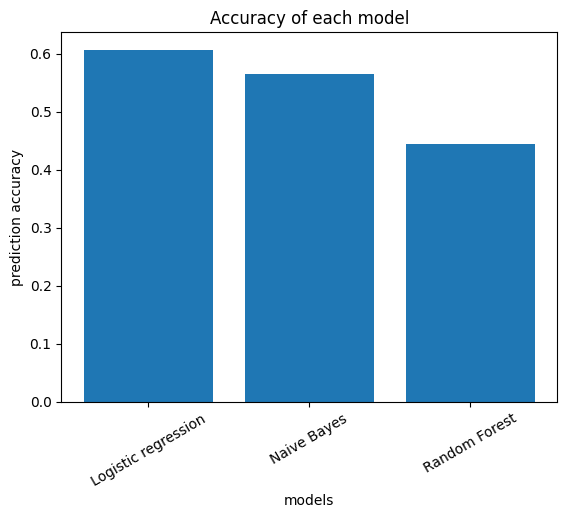

In [13]:
import matplotlib.pyplot as plt
import numpy as np
model = ['Logistic regression', 'Naive Bayes', 'Random Forest']
accuracy = [lr_accuracy,nbAccuracy,rfAccuracy]
index = np.arange(len(model))
plt.bar(index, accuracy)
plt.xlabel('models', fontsize=10)
plt.ylabel('prediction accuracy', fontsize=10)
plt.xticks(index, model, fontsize=10, rotation=30)
plt.title('Accuracy of each model')
plt.show()

In [14]:
# Fetching the tweets from  Reddit social network.

import praw

def get_sentiment_text(query):
        # API credentials
        client_id = 'msVOcvbKWhwpdfqFJLrlZw'
        client_secret = 'rK_rRaeS3DOj2Fp_lP2ecFW_b4vHNg'
        user_agent = 'praw_scraper_1'
        
        # Initialize PRAW with credentials
        reddit = praw.Reddit(client_id=client_id, client_secret=client_secret, user_agent=user_agent)
        
        # Search for Reddit posts in a specific subreddit
        search_query = query # Replace with search query
        
        # Maximum number of posts to retrieve
        max_posts = 10
        
        # Get the top 'max_posts' posts in the subreddit that match the search query
        posts = reddit.subreddit('all').search(search_query, limit=max_posts)

        results=[]
        
        # Iterate through the posts and print their titles and URLs
        
        
        for post in posts:
            #print(f'Title: {post.title}')
            results.append([str(post.title)])
            #print(f'URL: {post.url}')
            #print(f'URL: {post.author.name}')
            #print('---')

        return results

In [15]:
# Writting the tweets into the Reddit_test.csv file.

import csv


# field names 
fields = ['SentimentText'] 
   
# data rows of csv file 
rows =get_sentiment_text("Elections")

print(rows)
 
with open('Reddit_test.csv', 'w',encoding="utf-8") as f:
     
    # using csv.writer method from CSV package
    write = csv.writer(f)     
    write.writerow(fields)
    write.writerows(rows)


[['Who to vote for in the upcoming dutch elections'], ['Dutch elections exit poll: Geert Wilders’ right-wing PVV the largest'], ['2023 Dutch snap election'], ['Today are the Dutch elections. What do you choose?'], ['In light of the Dutch elections I made a pol comp of the most prominant parties'], ['⚡⚡⚡⚡⚡⚡ DUTCH ELECTION DONDERKOEPEL ⚡⚡⚡⚡⚡⚡⚡⚡'], ['Do you think the Dutch will lean more right wing or left wing in the upcoming elections?'], ['Netherlands 2023 election map by biggest party per municipality, by land and by number of voters'], ["It's not strange that when you make the American culture war your top priority, you're not going to be very successful in Dutch elections"], ['elections matter']]


In [16]:
import pandas as pd

data2 = spark.read.csv('Reddit_test.csv', inferSchema=True, header=True)
data2.show(truncate=False, n=10)

test_data=data2

tokenizer2 = Tokenizer(inputCol="SentimentText", outputCol="SentimentWords")
tokenizedTest2 = tokenizer2.transform(test_data)
tokenizedTest2.show(truncate=False)


swr2 = StopWordsRemover(inputCol=tokenizer2.getOutputCol(),
                       outputCol="MeaningfulWords")
SwRemovedTest = swr2.transform(tokenizedTest2)
SwRemovedTest.show(truncate=False)




+-----------------------------------------------------------------------------------------------------------------------------------------+
|SentimentText                                                                                                                            |
+-----------------------------------------------------------------------------------------------------------------------------------------+
|Who to vote for in the upcoming dutch elections                                                                                          |
|Dutch elections exit poll: Geert Wilders’ right-wing PVV the largest                                                                     |
|2023 Dutch snap election                                                                                                                 |
|Today are the Dutch elections. What do you choose?                                                                                       |
|In light of the Dut

In [17]:
hashTF2 = HashingTF(inputCol=swr2.getOutputCol(), outputCol="features",numFeatures=500)
numericTest2 = hashTF2.transform(SwRemovedTest).select('MeaningfulWords', 'features')
numericTest2.show(truncate=False)

+--------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------+
|MeaningfulWords                                                                             |features                                                                                        |
+--------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------+
|[vote, upcoming, dutch, elections]                                                          |(500,[40,83,214,330],[1.0,1.0,1.0,1.0])                                                         |
|[dutch, elections, exit, poll:, geert, wilders’, right-wing, pvv, largest]                  |(500,[40,61,67,83,187,244,330,406,451],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0])                   |
|[2023, dutch, snap, election]          

In [18]:
# performing the Sentiment Analysis prediction by passing the posts of the reddit social network. 

prediction = lr_model.transform(numericTest2) # Prediction

predictionFinal = prediction.select("MeaningfulWords", "prediction")

predictionFinal.show(truncate = False)

+--------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                             |prediction|
+--------------------------------------------------------------------------------------------+----------+
|[vote, upcoming, dutch, elections]                                                          |0.0       |
|[dutch, elections, exit, poll:, geert, wilders’, right-wing, pvv, largest]                  |0.0       |
|[2023, dutch, snap, election]                                                               |0.0       |
|[today, dutch, elections., choose?]                                                         |0.0       |
|[light, dutch, elections, made, pol, comp, prominant, parties]                              |0.0       |
|[⚡⚡⚡⚡⚡⚡, dutch, election, donderkoepel, ⚡⚡⚡⚡⚡⚡⚡⚡]                                           |0.0       |
|[think, dutch, lean, right, wing, left, wing,